# Supply Chain Order Demand Forecasting
This project is for learning purpose. 

First, import the necessary libraries and start to prepare dataframe. 
The next step is to study the dataset and clean the data for training and prediction.

Data preprocess

1. study the number of columns available in the file, data type of each columns
2. convert the date field to datetime as the model will fail to process date as object 
3. understand the data volume
4. drop any null values 


In [1]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import sys
from dateutil.parser import parse
import datetime
import os

In [2]:
import boto3
import s3fs
import sagemaker
from sagemaker import get_execution_role

In [3]:
# session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# create an S3 bucket
bucket = sagemaker_session.default_bucket()

In [4]:
# should be the name of directory you created to save your features data
bucket= 'sagemaker-ap-southeast-1-189221944944'
data_dir = 'forecast_data'

# set prefix, a descriptive name for a directory  
prefix = 'forecast_detection'

data_key = 'HistoricalProductDemand.csv'
#s3://sagemaker-ap-southeast-1-189221944944/HistoricalProductDemand.csv

s3_data_path = 's3://{}/{}'.format(bucket, data_key)
s3_output_path = "{}/{}/output".format(bucket, prefix)

In [6]:
data = pd.read_csv(s3_data_path, parse_dates=True, index_col=0)
data.head()

,Warehouse,Product_Category,Date,Order_Demand
Product_Code,,,,
Product_0993,Whse_J,Category_028,7/27/2012,100
Product_0979,Whse_J,Category_028,1/19/2012,500
Product_0979,Whse_J,Category_028,2/3/2012,500
Product_0979,Whse_J,Category_028,2/9/2012,500
Product_0979,Whse_J,Category_028,3/2/2012,500


In [7]:
data.dtypes

Warehouse           object
Product_Category    object
Date                object
Order_Demand         int64
dtype: object

In [8]:
data["Date"]= pd.to_datetime(data["Date"])
data.dtypes

Warehouse                   object
Product_Category            object
Date                datetime64[ns]
Order_Demand                 int64
dtype: object

In [9]:
data.shape

(1048575, 4)

In [10]:
data.head(10)

,Warehouse,Product_Category,Date,Order_Demand
Product_Code,,,,
Product_0993,Whse_J,Category_028,2012-07-27,100
Product_0979,Whse_J,Category_028,2012-01-19,500
Product_0979,Whse_J,Category_028,2012-02-03,500
Product_0979,Whse_J,Category_028,2012-02-09,500
Product_0979,Whse_J,Category_028,2012-03-02,500
Product_0979,Whse_J,Category_028,2012-04-19,500
Product_0979,Whse_J,Category_028,2012-06-05,500
Product_0979,Whse_J,Category_028,2012-06-27,500
Product_0979,Whse_J,Category_028,2012-07-23,500


In [11]:
missing = data.isnull().sum()
missing.sum()

11239

In [12]:
#Drop na's.

data.dropna(axis=0, inplace=True) #remove all rows with na's.
data.reset_index(drop=True)
data.sort_values('Date')[10:20] 

,Warehouse,Product_Category,Date,Order_Demand
Product_Code,,,,
Product_0642,Whse_C,Category_019,2011-10-31,3
Product_0202,Whse_A,Category_007,2011-11-04,-100
Product_0202,Whse_A,Category_007,2011-11-04,-400
Product_2143,Whse_S,Category_009,2011-11-18,-25
Product_0131,Whse_S,Category_021,2011-11-18,-12
Product_0288,Whse_S,Category_021,2011-11-18,-50
Product_0980,Whse_A,Category_028,2011-11-18,4000
Product_2138,Whse_S,Category_009,2011-11-18,-49
Product_2137,Whse_S,Category_009,2011-11-18,-25


Get the data range for time series analysis. Here, I have excluded 2011 and 2017 for many data is missing for these two years.
Then, convert the dataframe to show order demand by year as my objective is get the order demand forecast for the next 3 years. 

In [13]:
#Get the lowest and highest dates in the dataset.
data['Date'].min() , data['Date'].max()

(Timestamp('2011-01-08 00:00:00'), Timestamp('2017-01-09 00:00:00'))

In [69]:
data = data[(data['Date']>='2012-01-01') & (data['Date']<='2016-12-31')].sort_values('Date', ascending=True)

df = data.groupby('Date')['Order_Demand'].sum().reset_index()

In [71]:
#Index the date
df = df.set_index('Date')
df.index #Lets check the index

DatetimeIndex(['2012-01-01', '2012-01-02', '2012-01-03', '2012-01-04',
               '2012-01-05', '2012-01-06', '2012-01-08', '2012-01-09',
               '2012-01-10', '2012-01-11',
               ...
               '2016-12-20', '2016-12-21', '2016-12-22', '2016-12-23',
               '2016-12-25', '2016-12-26', '2016-12-27', '2016-12-28',
               '2016-12-29', '2016-12-30'],
              dtype='datetime64[ns]', name='Date', length=1681, freq=None)

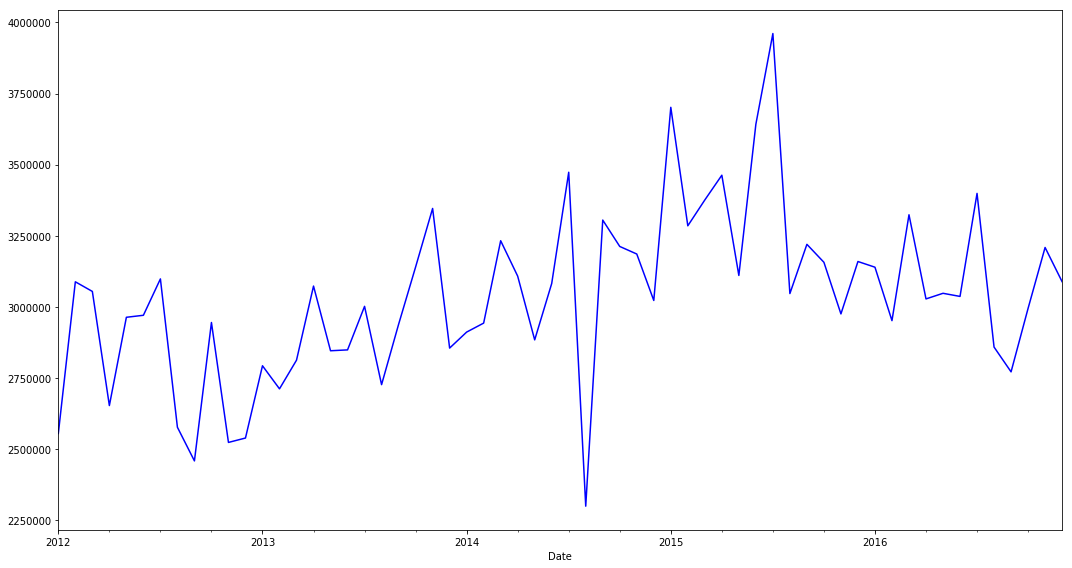

In [102]:
freq = 'm'
y = df['Order_Demand'].resample(freq).mean()


# display the mean values
plt.figure(figsize=(15,8))
y.plot(color='blue') 
plt.tight_layout()
plt.show()

In [103]:
df.info

<bound method DataFrame.info of             Order_Demand
Date                    
2012-01-01             2
2012-01-02        680277
2012-01-03       1645257
2012-01-04       1295861
2012-01-05       8941774
2012-01-06       4359137
2012-01-08        987149
2012-01-09       1442691
2012-01-10       5038088
2012-01-11       3285355
2012-01-12       2997584
2012-01-13       3645061
2012-01-15         64250
2012-01-16       4765938
2012-01-17       3461713
2012-01-18       2705838
2012-01-19       2892422
2012-01-20       2561289
2012-01-21           200
2012-01-22         13561
2012-01-23       2512968
2012-01-24       2490083
2012-01-25       2961600
2012-01-26       2827709
2012-01-27       2275134
2012-01-28          6200
2012-01-29        234083
2012-01-30       4703265
2012-01-31       5304346
2012-02-01       3681648
...                  ...
2016-11-27        890001
2016-11-28       4485743
2016-11-29       3862790
2016-11-30       5535632
2016-12-01       6221522
2016-12-02       5

In [117]:
def make_time_series(y, years, freq='M', start_idx=1):
     
    # store time series
    time_series = []
    
    # store leap year in this dataset
    leap = '2012'

    # create time series for each year in years
    for i in range(len(years)):

        year = years[i]
        if(year == leap):
            end_idx = start_idx+366
        else:
            end_idx = start_idx+365

        # create start and end datetimes
        t_start = year + '-01-01' # Jan 1st of each year = t_start
        t_end = year + '-12-31' # Dec 31st = t_end

        # get global consumption data
        data = y[start_idx:end_idx]

        # create time series for the year
        index = pd.DatetimeIndex(start=t_start, end=t_end, freq=freq)
        time_series.append(pd.Series(data=data, index=index))
        
        start_idx = end_idx
    
    # return list of time series
    return time_series

In [118]:
# yearly time series for our three complete years
full_years = ['2013', '2014','2015']
freq='M' 

# make time series
time_series = make_time_series(y, full_years, freq=freq)

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:26: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.


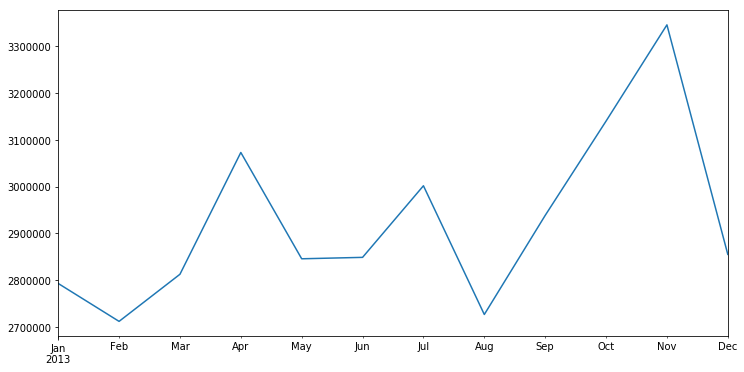

In [119]:
time_series_idx = 0

plt.figure(figsize=(12,6))
time_series[time_series_idx].plot()
plt.show()

In [122]:
def create_training_series(complete_time_series, prediction_length):
    '''Given a complete list of time series data, create training time series.
       :param complete_time_series: A list of all complete time series.
       :param prediction_length: The number of points we want to predict.
       :return: A list of training time series.
       '''
    # get training series
    time_series_training = []
    
    for ts in complete_time_series:
        # truncate trailing 30 pts
        time_series_training.append(ts[:-prediction_length])
        
    return time_series_training

In [123]:
prediction_length = 3 

time_series_training = create_training_series(time_series, prediction_length)

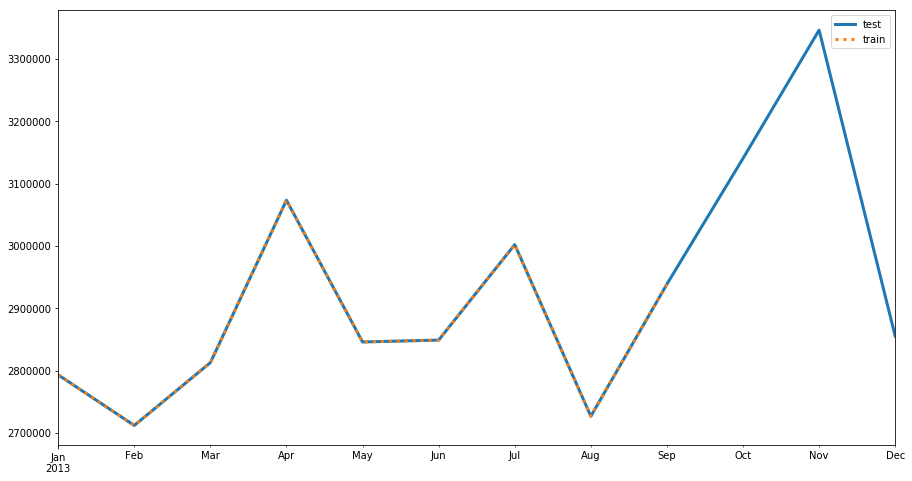

In [124]:
# display train/test time series
time_series_idx = 0

plt.figure(figsize=(15,8))
# test data is the whole time series
time_series[time_series_idx].plot(label='test', lw=3)
# train data is all but the last prediction pts
time_series_training[time_series_idx].plot(label='train', ls=':', lw=3)

plt.legend()
plt.show()

Before proceeding with SARIMA model, check how is the data skew. 
For this case, it is pretty low which is good. 

In [141]:
df['Order_Demand'].skew()

0.0199098134975783

More visualization on different angels to check if seasonal trend affect the order demand. 

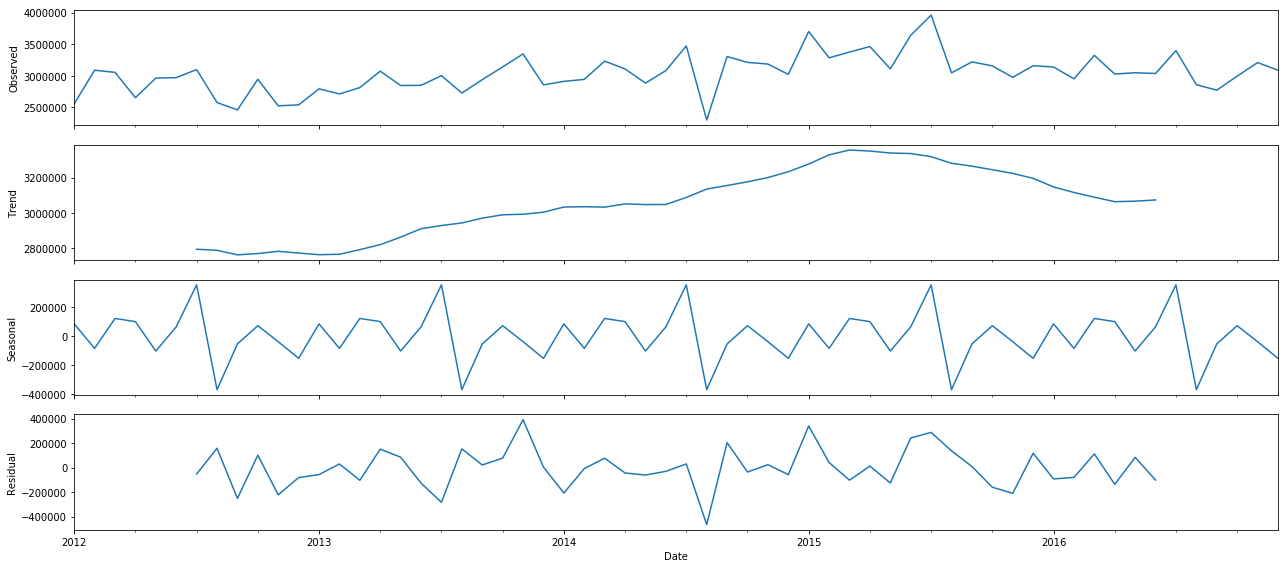

In [142]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

Training and prediction

In [143]:
import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [144]:

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1931.5634282849132
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1512.4361148419835
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1339.6881722069236
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:3234.861516311762
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1367.342362003335
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1341.6788736718381
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1023.8874178559138
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:3091.4610645059374
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1861.4667190337007
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1470.6819924566394
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1306.1619297383033
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:3152.594619542454
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1528.580793665934
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1467.1406721760193
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1021.2043416532863
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:3035.478709907959
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1649.0725000572024
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AI

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:1335.4277790813296
SARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:990.3503626070177
SARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:3120.4975478350443
SARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:1620.8889310884022
SARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:1286.8410694831016
SARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:1301.995461846814
SARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:3144.804439867688
SARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:1340.1954230168155
SARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:1287.6166884880677
SARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:987.6749622026332
SARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:3027.688530233193
SARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:1635.793447266306
SARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:1296.620632067356
SARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:1308.5607572932208
SARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:3056.6948464912302
SARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:1293.90241867624
SARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:1295.3773101490733
SARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:96

In [169]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(0, 1, 2),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6170      0.192     -3.212      0.001      -0.994      -0.241
ma.L2          0.0995      0.197      0.504      0.614      -0.287       0.486
ar.S.L12      -0.2518      0.130     -1.936      0.053      -0.507       0.003
sigma2      1.088e+11   1.07e-13   1.01e+24      0.000    1.09e+11    1.09e+11


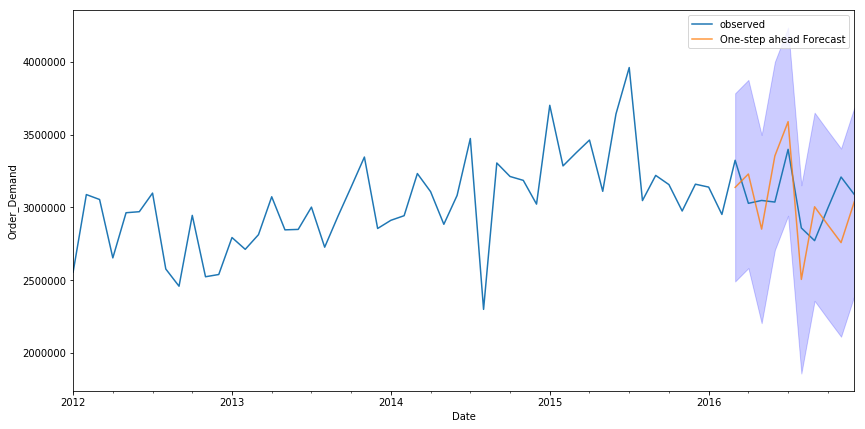

In [170]:
pred = results.get_prediction(start=50, dynamic=False) #false is when using the entire history.
#Confidence interval.
pred_ci = pred.conf_int()

#Plotting real and forecasted values.
ax = y['2012':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.8, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='blue', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Order_Demand')
plt.legend()
plt.show()

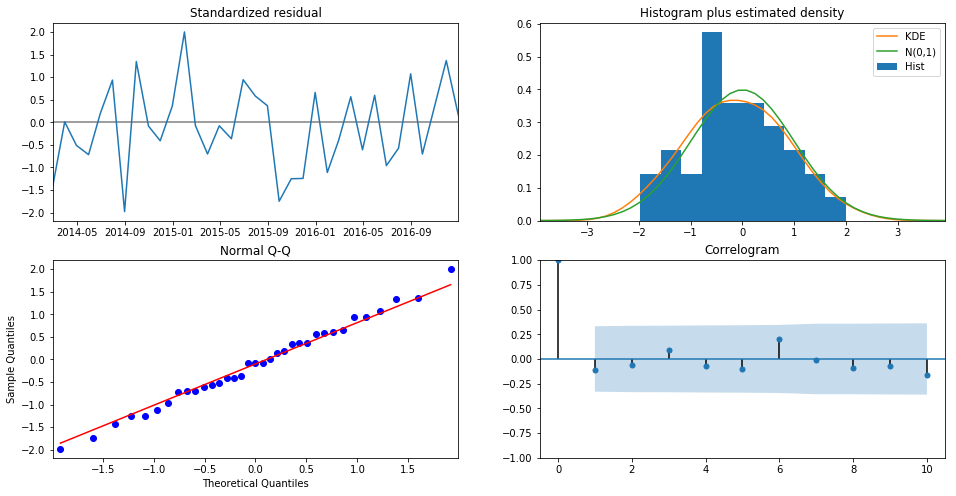

In [171]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


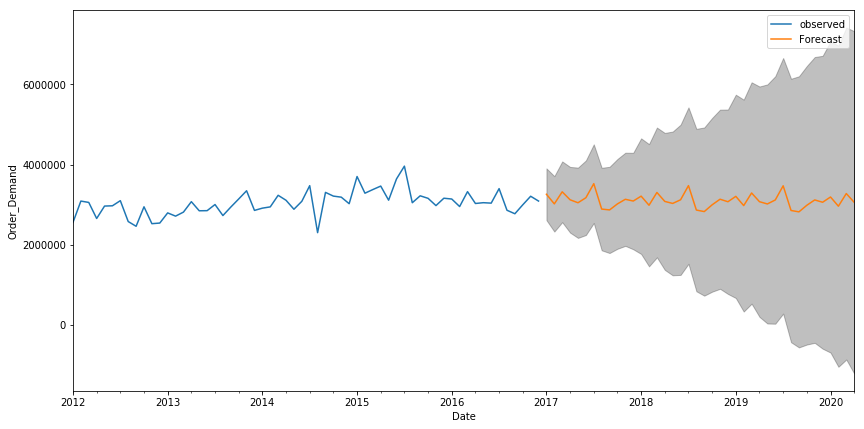

In [172]:
pred_uc = results.get_forecast(steps=40)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Order_Demand')
plt.legend()
plt.show()

In [173]:
#Getting the mean squared error (average error of forecasts).
y_forecasted = pred.predicted_mean
y_truth = y['2016-12-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('MSE {}'.format(round(mse, 2)))

#Smaller the better.

MSE 2469360609.11


In [174]:
print('RMSE: {}'.format(round(np.sqrt(mse), 2)))

RMSE: 49692.66


MSE and RMSE is pretty large though. The model can be further optimized by fine tuning with different sets of parameters. 

Udacity Machine Learning Nano Degree Capstone Project
Sammy Lee
June 20, 2020